<a href="https://colab.research.google.com/github/emely3h/Geospatial_ML/blob/feature%2Funet-experiment-1/notebooks/unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training an Unet

This notebook aims to train an Unet to make predictions based on a small subset of the dataset. We will use one original image for training, one for validation and one for testing.


### 0. Helper Classes

In [52]:
import numpy as np
from tensorflow import keras
import pickle


class EvaluationMetrics:
    """
        This class calculates and summarizes evaluation metrics based on the predicted and true labels.
    """

    def __init__(self, x_train, x_val, x_test, y_train, y_val, y_test, y_pred, dataset, training_dates, validation_dates, testing_dates, tile_size, step_size,
                 run_count):
       
        self.y_pred = y_pred
        if dataset == 'training':
          self.y_true = y_train
        elif dataset == 'validation':
          self.y_true = y_val
        elif dataset == 'testing':
          self.y_true = y_test
        else: 
          raise Exception(f'Specify the dataset to be used for calculating the metrics. The string has to be either "testing", "training" or "validation", however it was {dataset}.')
        
        self.class_statistics = self.get_statistics(x_train, x_val, x_test, y_train, y_val, y_test)

        self.training_dates = training_dates
        self.validation_dates = validation_dates
        self.testing_dates = testing_dates
        self.tile_size = tile_size
        self.step_size = step_size
        self.run_count = run_count

        self.jacard = self.jacard_coef(self.y_true, y_pred)



        self.conf_matrix_land = self.confusion_matrix(self.y_true, y_pred, 2)
        self.conf_matrix_valid = self.confusion_matrix(self.y_true, y_pred, 1)
        self.conf_matrix_invalid = self.confusion_matrix(self.y_true, y_pred, 0)

        self.precision_land = self.precision(self.conf_matrix_land)
        self.sensitivity_recall_land = self.sensitivity_recall(self.conf_matrix_land)
        self.specificy_land = self.specificy(self.conf_matrix_land)

        self.precision_valid = self.precision(self.conf_matrix_valid)
        self.sensitivity_recall_valid = self.sensitivity_recall(self.conf_matrix_valid)
        self.specificy_valid = self.specificy(self.conf_matrix_valid)

        self.precision_invalid = self.precision(self.conf_matrix_invalid)
        self.sensitivity_recall_invalid = self.sensitivity_recall(self.conf_matrix_invalid)
        self.specificy_invalid = self.specificy(self.conf_matrix_invalid)

        self.f1_land = self.f1_scores(self.conf_matrix_land)
        self.f1_invalid = self.f1_scores(self.conf_matrix_invalid)
        self.f1_valid = self.f1_scores(self.conf_matrix_valid)

    def jacard_coef(self, y_true, y_pred):
        y_true_f = keras.backend.flatten(y_true)
        y_pred_f = keras.backend.flatten(y_pred)

        intersection = keras.backend.sum(y_true_f * y_pred_f)
        return (intersection + 1.0) / (
                keras.backend.sum(y_true_f) + keras.backend.sum(y_pred_f) - intersection + 1.0
        )  #todo reason for +1?

    def jacard_rounding_issue(self, y_true, y_pred):
        # revert one hot encoding => binary tensor [0, 0, 1] back to label [2] (3D array to 2D array)
        label_map_true = np.argmax(y_true, axis=-1)
        label_map_pred = np.argmax(y_pred, axis=-1)
        # convert 2D array into 1D array
        flatten_true = np.reshape(label_map_true, (-1,))
        flatten_pred = np.reshape(label_map_pred, (-1,))
        # one hot encoding
        one_hot_true = np.eye(3)[flatten_true]
        one_hot_pred = np.eye(3)[flatten_pred]
        # calculate intersection (A geschnitten B)
        intersection = np.sum(one_hot_true * one_hot_pred)
        # calculate union (a u B, A vereint B)
        union = len(one_hot_true) + len(one_hot_pred) - intersection
        # return jacard coefficient
        return (intersection + 1) / (union + 1)

    def confusion_matrix(self, y_true, y_pred, label):
        true_positives = 0
        false_positives = 0
        true_negatives = 0
        false_negatives = 0

        # revert one hot encoding => binary tensor [0, 0, 1] back to label [2] (3D array to 2D array)
        label_map_true = np.argmax(y_true, axis=-1)
        label_map_pred = np.argmax(y_pred, axis=-1)
        # convert 2D array into 1D array
        flatten_true = np.reshape(label_map_true, (-1,))
        flatten_pred = np.reshape(label_map_pred, (-1,))

        tp_mask = (flatten_true == flatten_pred) & (flatten_true == label)
        true_positives = np.count_nonzero(tp_mask)

        fn_mask = (flatten_true == label) & (flatten_pred != label)
        false_negatives = np.count_nonzero(fn_mask)

        fp_mask = (flatten_true != label) & (flatten_pred == label)
        false_positives = np.count_nonzero(fp_mask)

        tn_mask = (flatten_true != label) & (flatten_pred != label)
        true_negatives = np.count_nonzero(tn_mask)

        return {
            'true_positives': true_positives,
            'false_positives': false_positives,
            'true_negatives': true_negatives,
            'false_negatives': false_negatives
        }

    def precision(self, conf_matrix):
        return conf_matrix['true_positives'] / (conf_matrix['true_positives'] + conf_matrix['false_positives'])

    def sensitivity_recall(self, conf_matrix):
        return conf_matrix['true_positives'] / (conf_matrix['true_positives'] + conf_matrix['false_negatives'])

    def negative_predictive(self, conf_matrix):
        return conf_matrix['true_negatives'] / (conf_matrix['true_negatives'] + conf_matrix['false_negatives'])

    def specificy(self, conf_matrix):
        return conf_matrix['true_negatives'] / (conf_matrix['true_negatives'] + conf_matrix['false_positives'])

    def f1_scores(self, conf_matrix):
        prec = self.precision(conf_matrix)
        recall = self.sensitivity_recall(conf_matrix)
        return 2 * prec * recall / (prec + recall)

    def print_metrics(self):
        print(f'jacard index: {self.jacard} \n')

        print(f'precision_land: {self.precision_land}')
        print(f'precision_valid: {self.precision_valid}')
        print(f'precision_invalid: {self.precision_invalid} \n')

        print(f'recall_invalid_land: {self.sensitivity_recall_land}')
        print(f'recall_invalid_land: {self.sensitivity_recall_valid}')
        print(f'recall_invalid_land: {self.sensitivity_recall_invalid} \n')

        print(f'specificy_invalid_land: {self.specificy_land}')
        print(f'specificy_invalid_valid: {self.specificy_valid}')
        print(f'specificy_invalid_invalid: {self.specificy_invalid} \n')

        print(f'f1_land: {self.f1_land}')
        print(f'f1_invalid: {self.f1_invalid}')
        print(f'f1_valid: {self.f1_valid}')

        print(f'Training dates: {self.training_dates}, validation dates: {self.validation_dates}, testing dates: {self.testing_dates}')
        print(f'Number of run: {self.run_count}, tile_size: {self.tile_size}, step_size: {self.step_size}')

    def save_to_file(self):
        file_name = f'../metrics/{self.tile_size}_{self.step_size}_{self.run_count}.pkl'
        with open(file_name, 'wb') as file:
            pickle.dump(self, file)

    def get_label_count(self, array):
        revert_one_hot = np.argmax(array, (-1))
        flatten = np.reshape(revert_one_hot, (-1))
        unique_vals, counts = np.unique(flatten, return_counts=True)
        label_count = {}
        for val, count in zip(unique_vals, counts):
            label_count[f'{val}'] = count
        return label_count

    def get_statistics(self, x_train, x_val, x_test, y_train, y_val, y_test):
       return {'y_train': self.get_label_count(y_train),
                 'y_val': self.get_label_count(y_val), 'y_test': self.get_label_count(y_test)}
    # todo add pixel accuracy


### 1. Loading Data

In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
#! ls
%cd drive/MyDrive/MachineLearning
%cd Geospatial_ML
! ls

[Errno 2] No such file or directory: 'drive/MyDrive/MachineLearning'
/content/drive/.shortcut-targets-by-id/15HUD3sGdfvxy5Y_bjvuXgrzwxt7TzRfm/MachineLearning/Geospatial_ML
[Errno 2] No such file or directory: 'Geospatial_ML'
/content/drive/.shortcut-targets-by-id/15HUD3sGdfvxy5Y_bjvuXgrzwxt7TzRfm/MachineLearning/Geospatial_ML
architecture.drawio  evaluation  notebooks     README.md
Copy_of_unet.ipynb   models	 prepare_data  requirements.txt


In [25]:
#! git clone https://github.com/emely3h/Geospatial_ML
#%cd Geospatial_ML
! git pull
! ls

Already up to date.
architecture.drawio  evaluation  notebooks     README.md
Copy_of_unet.ipynb   models	 prepare_data  requirements.txt


In [26]:
!git checkout feature/unet-experiment-1

M	evaluation/evaluation_metrics.py
Already on 'feature/unet-experiment-1'
Your branch is up to date with 'origin/feature/unet-experiment-1'.


In [27]:
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import (
    Input,
    Conv2D,
    MaxPooling2D,
    concatenate,
    Conv2DTranspose,
    Dropout,
    UpSampling2D
)
from keras.losses import categorical_crossentropy
from tensorflow.keras.callbacks import EarlyStopping
import pickle

In [28]:
data_directory = "../data_colab/256_200"

y_train  = np.load(os.path.join(data_directory, '2022_06_20.npz'))['y_mask']
x_train  = np.load(os.path.join(data_directory, '2022_06_20.npz'))['x_input']

y_val = np.load(os.path.join(data_directory, '2022_07_10.npz'))['y_mask']
x_val = np.load(os.path.join(data_directory, '2022_07_10.npz'))['x_input']

y_test = np.load(os.path.join(data_directory, '2022_07_25.npz'))['y_mask']
x_test = np.load(os.path.join(data_directory, '2022_07_25.npz'))['x_input']

print(y_train.shape)
print(x_train.shape)

print(y_val.shape)
print(x_val.shape)

print(y_test.shape)
print(x_test.shape)

(1251, 256, 256)
(1251, 256, 256, 5)
(1323, 256, 256)
(1323, 256, 256, 5)
(1258, 256, 256)
(1258, 256, 256, 5)


### 2. Diyplay Images

In [29]:
def display_image(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    if len(display_list[i].shape) == 3:
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        #plt.axis('off')
    else:
        plt.imshow(display_list[i])
  plt.show()

def display(list_train, list_mask):
  for idx, img_train in enumerate(list_train):
    sample_image, sample_mask = list_train[idx], list_mask[idx]
    sample_image = sample_image[..., :4]
    display_image([sample_image, sample_mask])

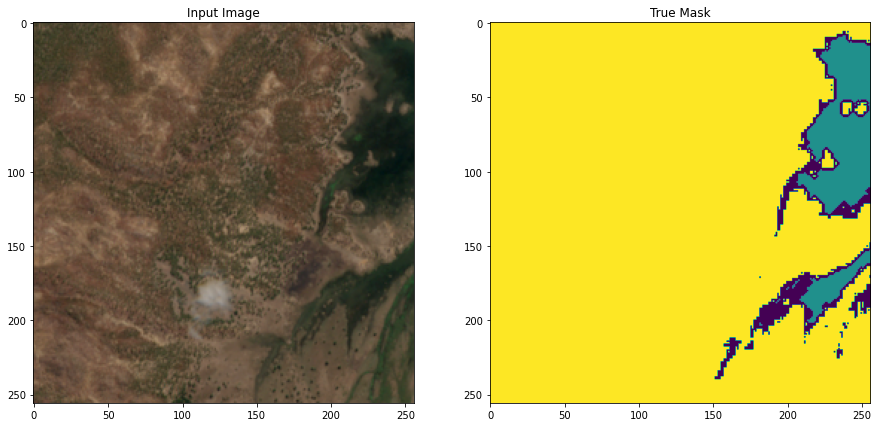

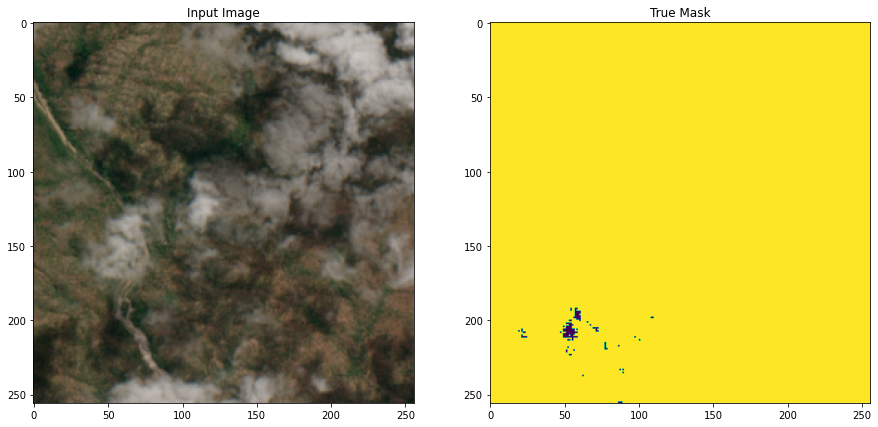

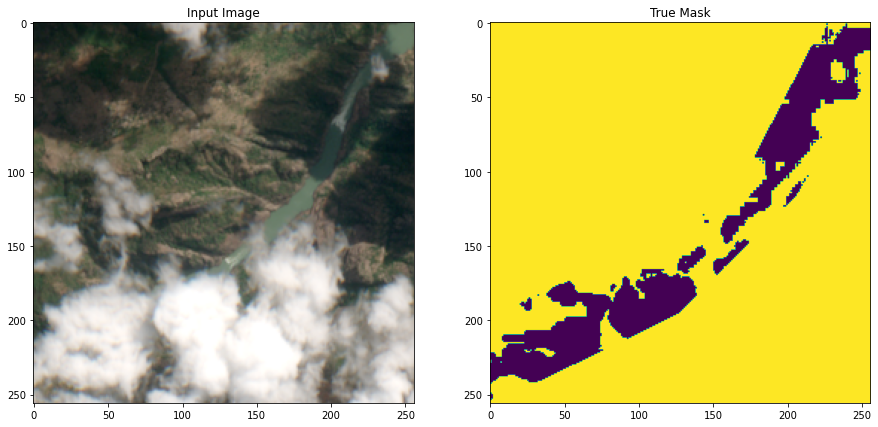

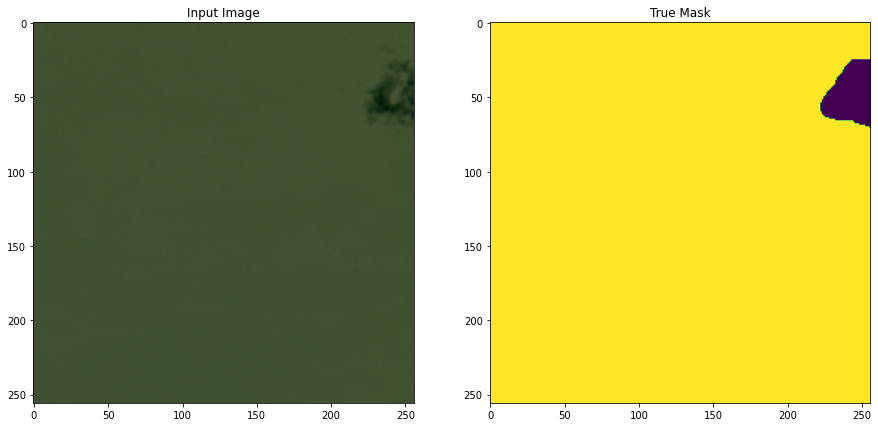

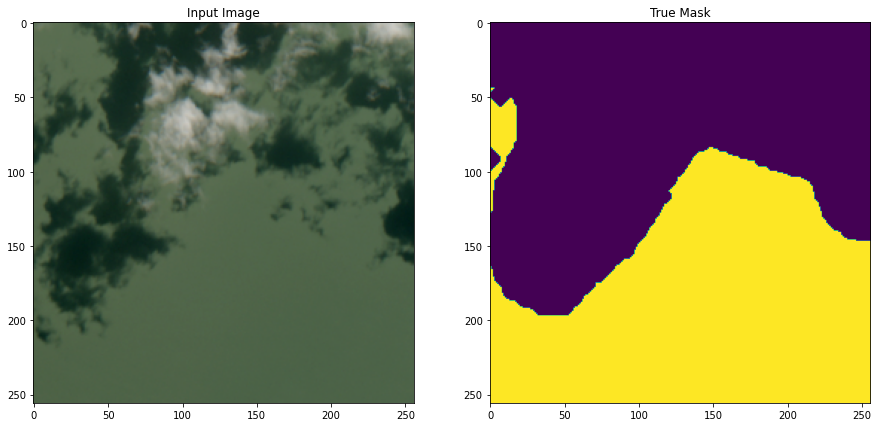

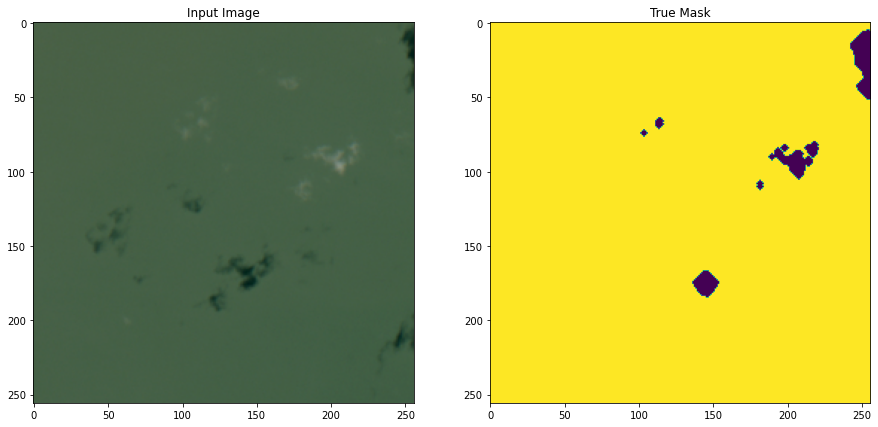

In [30]:
display(x_train[:6], y_train[:6])

### 3. Normalizing + Encoding

In [31]:
def normalizing(X, y):

  print(y.shape)
  y_one_hot =  np.array([tf.one_hot(item, depth=3).numpy() for item in y])
  print(y_one_hot.shape)
  X_normal = X/255
  return X_normal, y_one_hot

In [32]:
x_train, y_train = normalizing(x_train, y_train)

X_val, y_val = normalizing(x_val, y_val)

x_test, y_test = normalizing(x_test, y_test)


(1251, 256, 256)
(1251, 256, 256, 3)
(1323, 256, 256)
(1323, 256, 256, 3)
(1258, 256, 256)
(1258, 256, 256, 3)


### 4. Compiling the model

In [33]:
def unet_2d(input_shape, num_classes):

    # Define the input layer
    inputs = Input(input_shape)

    # Downsample layers
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)

    # Upsample layers
    up5 = concatenate([UpSampling2D(size=(2, 2))(conv4), conv3], axis=-1)
    conv5 = Conv2D(256, (3, 3), activation='relu', padding='same')(up5)
    conv5 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv2], axis=-1)
    conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv1], axis=-1)
    conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv7)

    # Output layer
    output = Conv2D(num_classes, (1, 1), activation='softmax')(conv7)

    # Define the model
    model = Model(inputs=[inputs], outputs=[output])

    return model

In [34]:
model = unet_2d(input_shape=(256, 256, 5), num_classes=3)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 5  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_15 (Conv2D)             (None, 256, 256, 64  2944        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_16 (Conv2D)             (None, 256, 256, 64  36928       ['conv2d_15[0][0]']              
                                )                                                           

### 5. Training the model

In [56]:
model.compile(optimizer='adam',
              loss=categorical_crossentropy,
              metrics=['accuracy']) 

early_stop = EarlyStopping(monitor='accuracy', patience=5) ## alternatives for monitor?? val_loss

model_history = model.fit(x=x_train, y=y_train, epochs=100, validation_data=(x_val, y_val), callbacks=[early_stop])



Epoch 1/100
40/40 [==============================] - 17s 307ms/step - loss: 0.0738 - accuracy: 0.9741 - val_loss: 5.4873 - val_accuracy: 0.9835
Epoch 2/100
40/40 [==============================] - 10s 240ms/step - loss: 0.0246 - accuracy: 0.9910 - val_loss: 6.8826 - val_accuracy: 0.9845
Epoch 3/100
40/40 [==============================] - 10s 241ms/step - loss: 0.0168 - accuracy: 0.9938 - val_loss: 10.2837 - val_accuracy: 0.9797
Epoch 4/100
40/40 [==============================] - 10s 240ms/step - loss: 0.0125 - accuracy: 0.9953 - val_loss: 11.8188 - val_accuracy: 0.9816
Epoch 5/100
40/40 [==============================] - 10s 240ms/step - loss: 0.0105 - accuracy: 0.9961 - val_loss: 13.1309 - val_accuracy: 0.9792
Epoch 6/100
40/40 [==============================] - 10s 241ms/step - loss: 0.0089 - accuracy: 0.9967 - val_loss: 10.9802 - val_accuracy: 0.9840
Epoch 7/100
40/40 [==============================] - 10s 240ms/step - loss: 0.0079 - accuracy: 0.9971 - val_loss: 15.3021 - val_accu

### 6. Training Results

In [73]:
def plot_loss_acc(plots, y_scale):
  loss = model_history.history['loss']
  val_loss = model_history.history['val_loss']
  acc = model_history.history['accuracy']
  val_acc = model_history.history['val_accuracy']

  plt.figure(figsize=(10,6))
  if 'loss' in plots:
    plt.plot(model_history.epoch, loss, 'g', label='Training Loss')
  if 'accuracy' in plots:
    plt.plot(model_history.epoch, acc, 'y', label='Training Accuracy')
  if 'val_loss' in plots:
    plt.plot(model_history.epoch, val_loss, 'r', label='Validation Loss')
  if 'val_accuracy' in plots:
    plt.plot(model_history.epoch, val_acc, 'b', label='Validation Accuracy')
  plt.title('')
  plt.xlabel('Epoch')
  plt.ylabel('Value')
  if y_scale == 'all':
    plt.ylim([0, 1])
  elif y_scale == 'loss':
    plt.ylim([0, 25])
  else:
    plt.ylim([0.8, 1])
  plt.legend()

  plt.show()

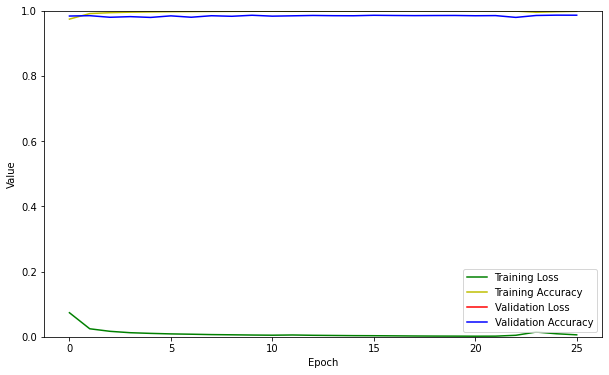

In [66]:
plot_loss_acc(['loss', 'accuracy', 'val_loss', 'val_accuracy'], 'all') ### val_loss not showing => does not fit on scale

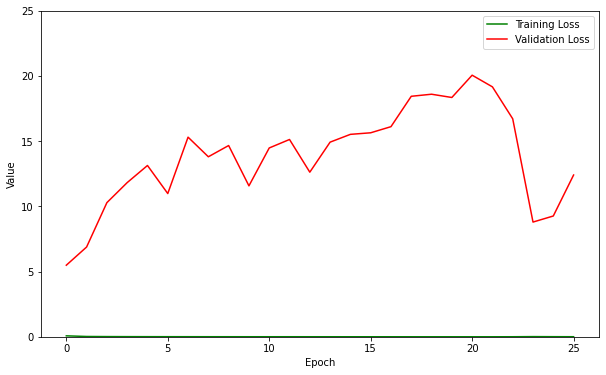

In [74]:
plot_loss_acc(['loss', 'val_loss',], 'loss')

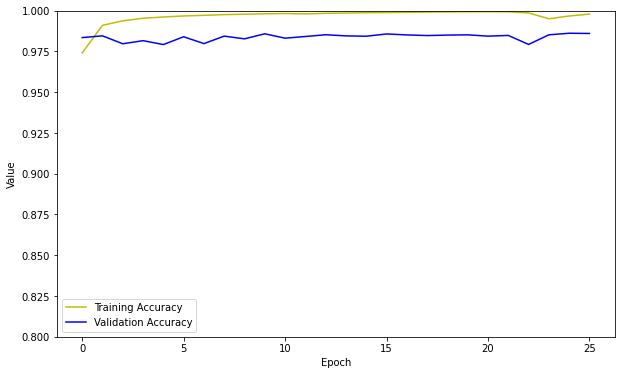

In [68]:
plot_loss_acc(['accuracy', 'val_accuracy'], 'accuracy')

### 7. Saving the model + history

In [69]:
model_name = 'model_256_200.h5'
model.save(f'../models/{model_name}')

with open('../models/history_256_200.pkl', 'wb') as file_pi:
    pickle.dump(model_history.history, file_pi)

#model = keras.models.load_model(f'../models/{model_name}')

#with open('../models/256_200_1_train_image_history.pickle', "rb") as file_pi:
#    history = pickle.load(file_pi)
#print(history['loss'])


### 8. Analyzing + saving metrics

In [70]:
pred_test = model.predict(x_test)
pred_val = model.predict(x_val)
pred_train = model.predict(x_train)

40/40 [==============================] - 2s 56ms/step


In [71]:
metrics_test = EvaluationMetrics(x_train, x_val, x_test, y_train, y_val, y_test, pred_test, 'testing', '2022_06_20', '2022_07_10.', '2022_07_25.', 256, 200, 4)
metrics_val = EvaluationMetrics(x_train, x_val, x_test, y_train, y_val, y_test, pred_val, 'validation', '2022_06_20', '2022_07_10.', '2022_07_25.', 256, 200, 4)
metrics_train = EvaluationMetrics(x_train, x_val, x_test, y_train, y_val, y_test, pred_train, 'training', '2022_06_20', '2022_07_10.', '2022_07_25.', 256, 200, 4)

with open('../metrics/metrics_256_200_testing.pkl', 'wb') as file_pi:
    pickle.dump(metrics_test, file_pi)
with open('../metrics/metrics_256_200_validation.pkl', 'wb') as file_pi:
    pickle.dump(metrics_val, file_pi)
with open('../metrics/metrics_256_200_training.pkl', 'wb') as file_pi:
    pickle.dump(metrics_train, file_pi)


print('========= TESTING METRICS ==========')
metrics_test.print_metrics()
print()
print()

print('========= VALIDATION METRICS ==========')
metrics_val.print_metrics()
print()
print()

print('========= TRAINING METRICS ==========')
metrics_train.print_metrics()

========= TESTING METRICS ==========
jacard index: 0.981717586517334 

precision_land: 0.9977882400043818
precision_valid: 0.9898473937185902
precision_invalid: 0.95775364339397 

recall_invalid_land: 0.9988900081391798
recall_invalid_land: 0.9952705080218291
recall_invalid_land: 0.9135314656720864 

specificy_invalid_land: 0.9980533511922207
specificy_invalid_valid: 0.991102295912356
specificy_invalid_invalid: 0.9971318658051683 

f1_land: 0.9983388200936552
f1_invalid: 0.9351200256588894
f1_valid: 0.992551543207239
Training dates: 2022_06_20, validation dates: 2022_07_10., testing dates: 2022_07_25.
Number of run: 4, tile_size: 256, step_size: 200


========= VALIDATION METRICS ==========
jacard index: 0.9723995327949524 

precision_land: 0.9997477599442683
precision_valid: 0.9765144117342063
precision_invalid: 0.9747460712968582 

recall_invalid_land: 0.9976290576341996
recall_invalid_land: 0.9803306162928412
recall_invalid_land: 0.9737490886629018 

specificy_invalid_land: 0.999810

### 9. Making predictions

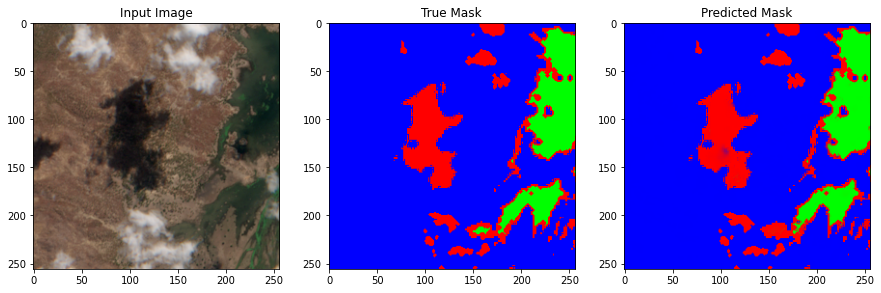

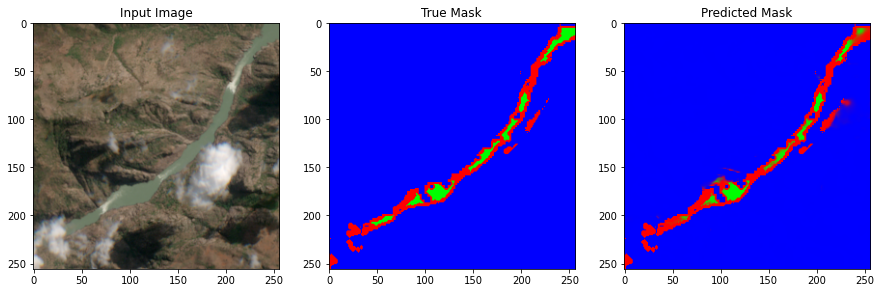

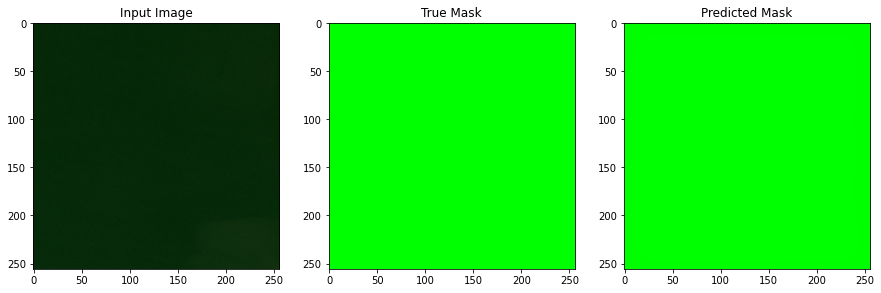

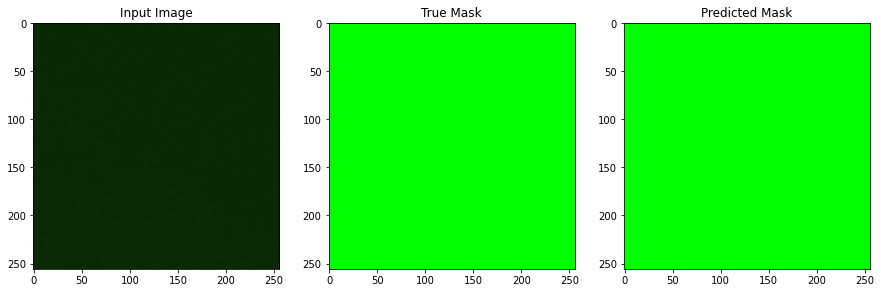

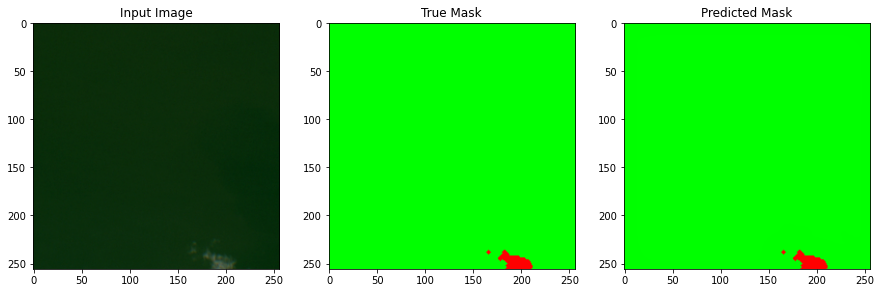

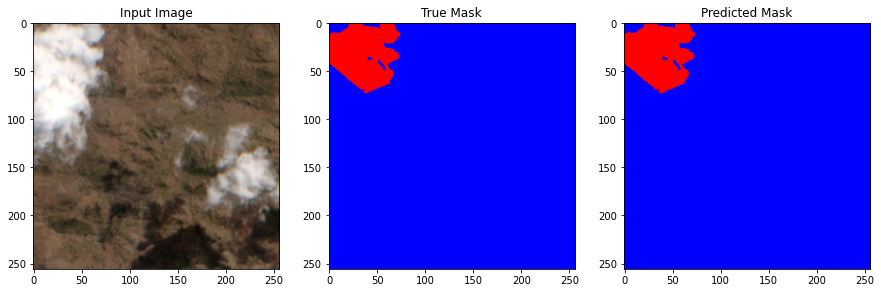

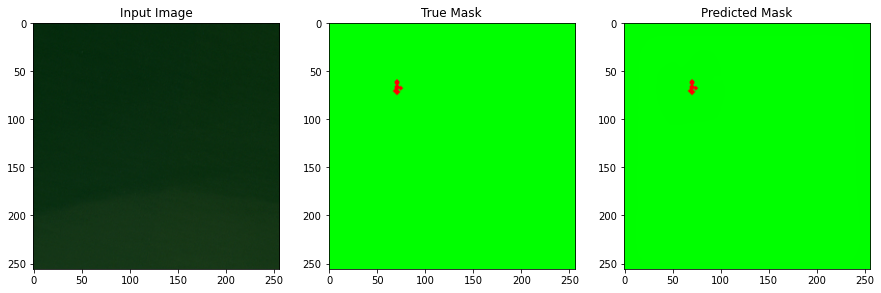

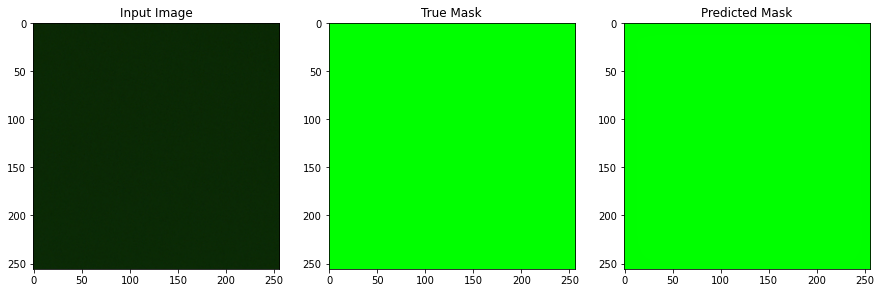

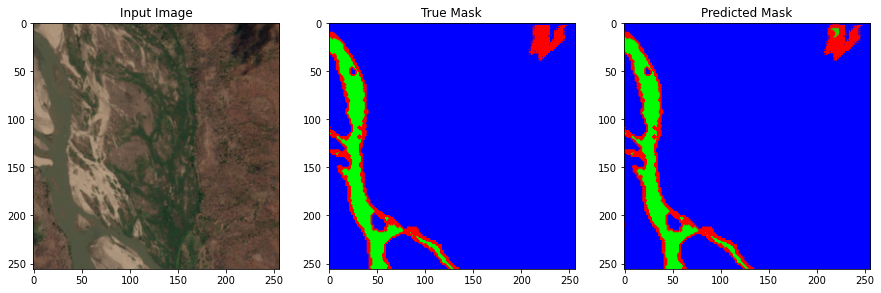

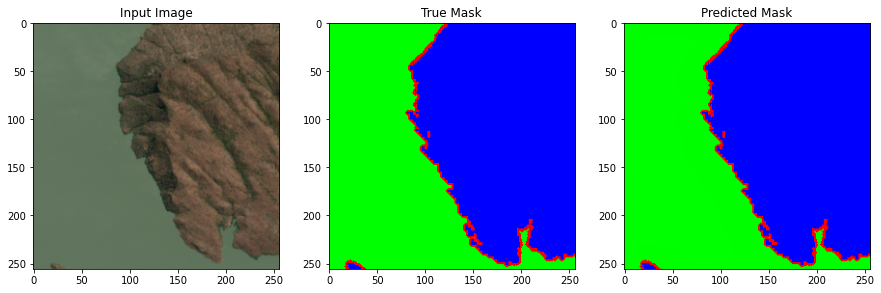

In [72]:
def make_predictions(x_input, y_true, y_pred):
  for idx, img in enumerate(x_input):
    x_img = x_input[idx]
    x_img = x_img[..., :4]
    display_image([x_img, y_test[idx], pred_test[idx]])

make_predictions(x_test[:10], y_test[:10], pred_test[:10])

### 10. Summary

entire notebook execution ~ 9 min
